# Here we create a few 2D plots

3 classes of plots:

- Error rate on x-axis

- n_row on x-axis

- n_col on x-axis

In all plots, we display each error mech with missing value and wrong unit (6 lines per plot)

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# Read in data
num_data = pd.read_csv("../results/numeric_times.csv")  # change this if you want to use the old data -- remove "_new"
str_data = pd.read_csv("../results/string_times.csv")  # change this if you want to use the old data -- remove "_new"
df = pd.concat([num_data, str_data], axis=0, ignore_index=True)  # The funny block matrix style is ok, nans are removed in the plotting after converting to long. This just made it easier to process.

In [27]:
def parse_metadata(df):
    # Parse metadata from column names
    metadata = []
    for col in df.columns:
        parts = col.split('-')
        if parts[-1] == 'mem_MB':
            metric = 'mem_MB'
            parts = parts[:-1]
        else:
            metric = 'runtime'

        if len(parts) != 5:
            continue  # skip malformed columns

        mechanism, errortype, errorrate, numrows, numcols = parts
        metadata.append({
            'colname': col,
            'mechanism': mechanism,
            'errortype': errortype,
            'errorrate': float(errorrate),
            'numrows': int(numrows),
            'numcols': int(numcols),
            'metric': metric
        })

    return pd.DataFrame(metadata)

In [28]:
# Get a metadata df
meta_df = parse_metadata(df)

filtered_meta = meta_df[meta_df['errortype'].isin(['MissingValue', 'WrongUnitScale10', 'Typo'])]

In [29]:
# Reshape into long

def make_long(df, metadata_df):
    records = []
    for _, row in metadata_df.iterrows():
        for _, val in df[row['colname']].items():
            records.append({
                'value': val,
                'metric': row['metric'],
                'Error Mechanism': row['mechanism'],
                'Error Type': row['errortype'],
                'errorrate': row['errorrate'],
                'numrows': row['numrows'],
                'numcols': row['numcols'],
                'label': row['mechanism'] + "-" + row['errortype']
            })
    return pd.DataFrame(records)

In [30]:
long_df = make_long(df, filtered_meta)

In [31]:
long_df['Error Type'].unique()

array(['MissingValue', 'WrongUnitScale10', 'Typo'], dtype=object)

In [32]:
# Plot code
def plot_2D(long_df, metric_filter = "runtime", x_axis = "numrows", error_types=['MissingValue', 'WrongUnitScale10', 'Typo']):
    """Plot the 2D plots as described above.
    metric_filter: one of ['runtime', 'mem_MB']
    x_axis: one of ['errorrate', 'numcols', 'numrows']
    """
    subset_df = long_df[
        (long_df['metric'] == metric_filter) &
        (long_df['Error Type'].isin(error_types))
    ].dropna()
    
    
    line_styles = {
        'EAR': (None,None),
        'ENAR': (5,5),
        'ECAR': (1,3),
    }
    
    error_colors = {
        'MissingValue': '#1f77b4',      # blue
        'WrongUnitScale10': '#ff7f0e',  # orange
        'Typo': '#2ca02c',              # green
    }
    
    unique_types = subset_df['Error Type'].unique()
    label_colors = {
        etype: error_colors[etype] for etype in unique_types
    }
    
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=subset_df,
        x=x_axis, y='value',
        hue='Error Type',
        style='Error Mechanism',
        style_order=['EAR', 'ENAR', 'ECAR'],
        dashes=line_styles,
        palette=label_colors,
        marker='o'
    )
    
    plt.xlabel(x_axis.capitalize())
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('Runtime (s)' if metric_filter == 'runtime' else 'Memory (MB)')
    plt.title(f"{'Runtime' if metric_filter == 'runtime' else 'Memory'} vs. {x_axis[:-4].capitalize() + ' ' + x_axis[-4:].capitalize()}")
    plt.legend(title='Mechanism-ErrorType', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()

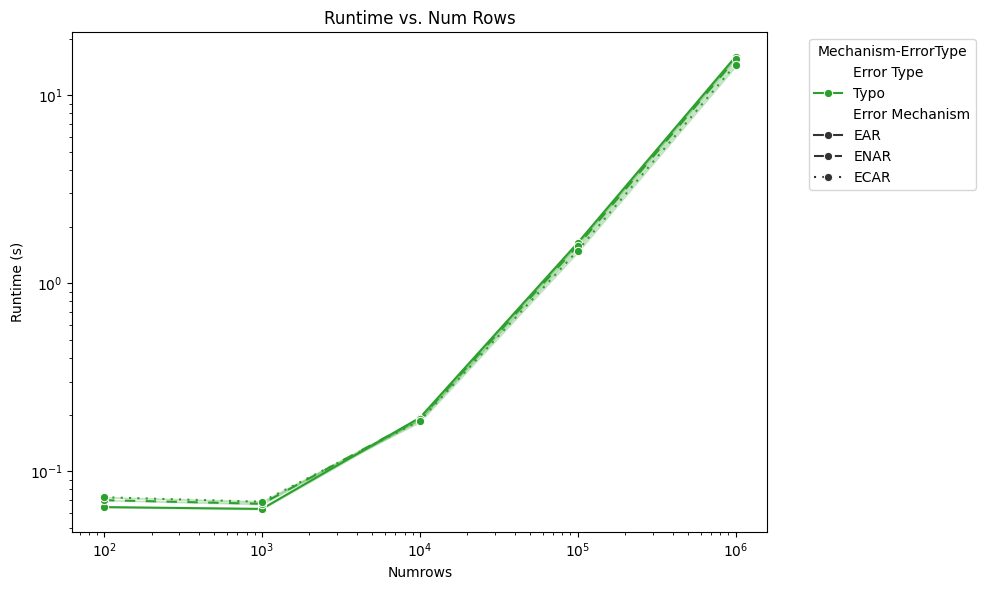

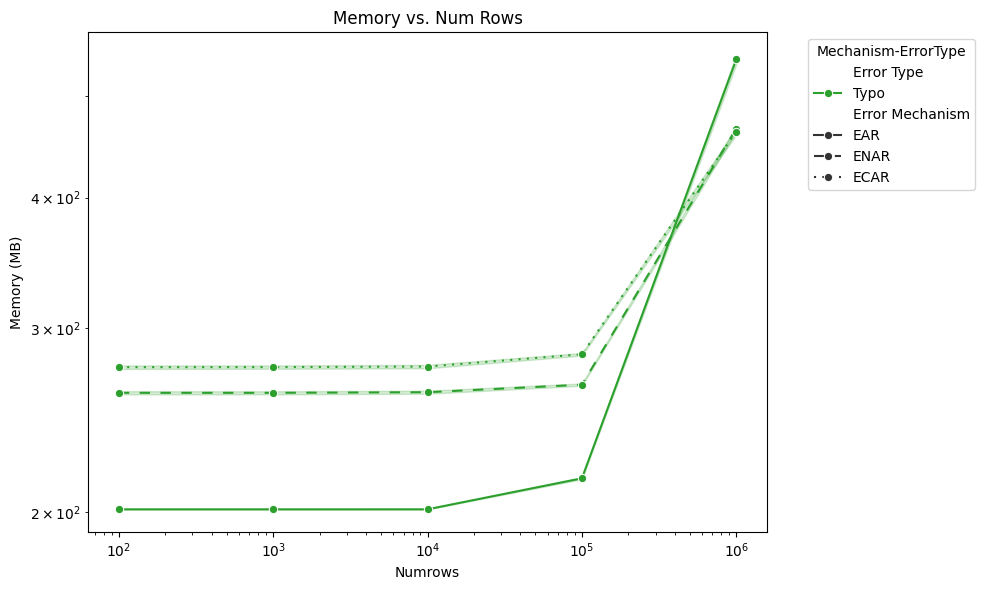

In [33]:
# Num Rows
plot_2D(long_df, error_types=["Typo"])  # Runtime
plot_2D(long_df, metric_filter="mem_MB", error_types=["Typo"])  # Memory

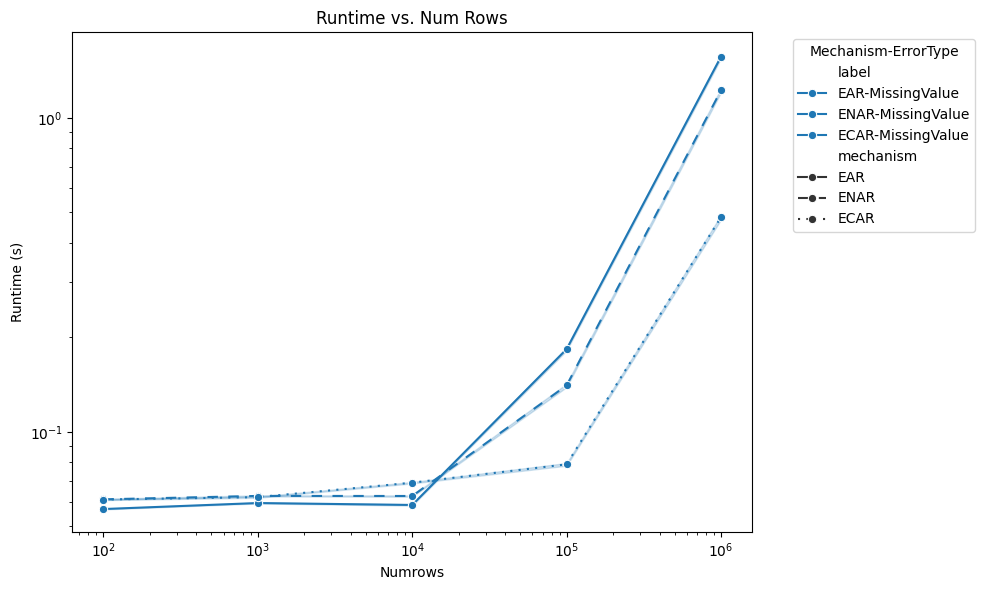

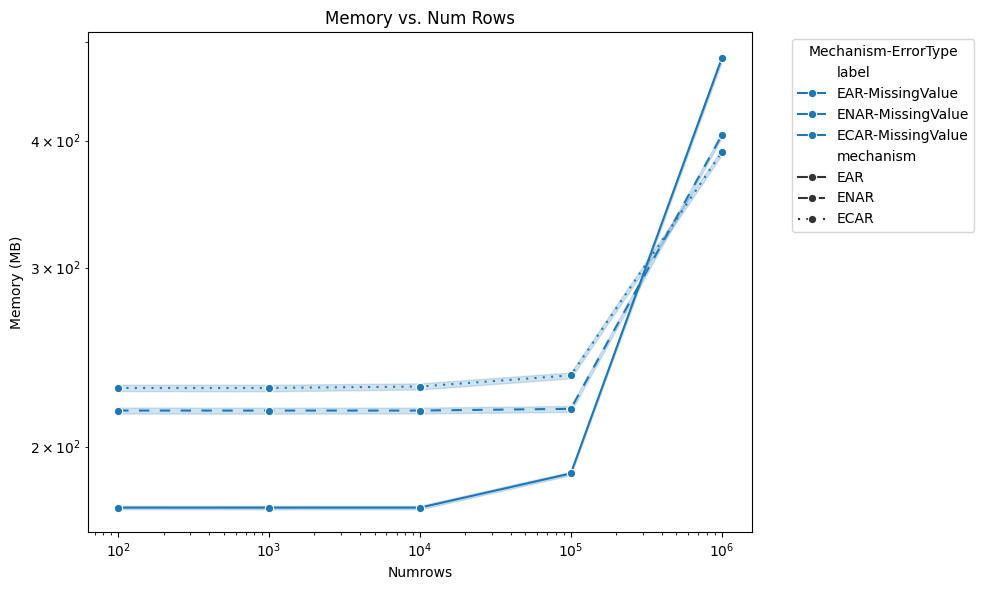

In [18]:
# Num Rows
plot_2D(long_df, error_types=["MissingValue"])  # Runtime
plot_2D(long_df, metric_filter="mem_MB", error_types=["MissingValue"])  # Memory


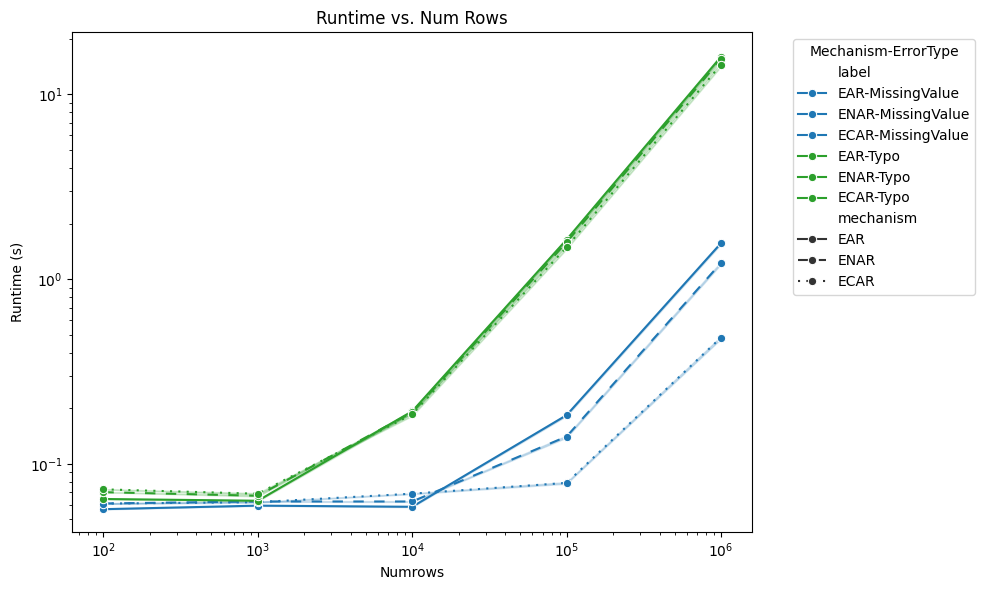

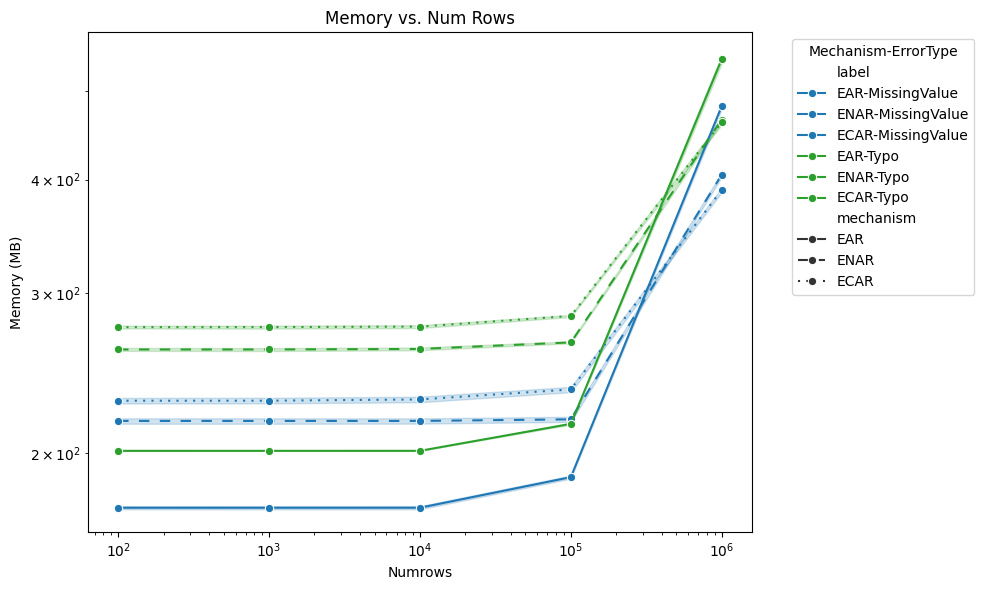

In [20]:
plot_2D(long_df, error_types=["MissingValue", "Typo"])  # Runtime
plot_2D(long_df, metric_filter="mem_MB", error_types=["MissingValue", "Typo"])  # Memory
